In [10]:
import numpy as np
import pandas as pd
import glob
from organoid_tracking import organoid_tracking
import os
from itertools import repeat


## analyzing an image sequence

we get the organoid properties sequentially and then link the individual organoids together using trackpy.

In [11]:
start_dir = '/Users/clemence/Documents_Clémence/Analysis/Tracking algorithm/Tracking-seg_Aaron-Gus_CNV/To run'

pattern   = "*/masks_predicted/*.tif"
fnames = []
validation_directories = []

for dir,_,_ in os.walk(start_dir):
    fnames.extend(glob.glob(os.path.join(dir,pattern)))

for fname in fnames:

    experiment_directory = '/'.join(fname.split('/')[:-2])

    validation_directory = experiment_directory + '/' + 'validation_image'
    validation_directories.append(validation_directory)

    if not os.path.exists(validation_directory):
        os.makedirs(validation_directory)

Frame 45: 1 trajectories present.


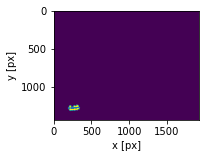

In [12]:

movie_frames = map(organoid_tracking.movie_analysis, fnames, validation_directories)

file_data = pd.DataFrame()
file_data = pd.concat(list(movie_frames), 
                      ignore_index=True)
file_data['unique_organoid'] = file_data['particle'].astype(str) + ':' + file_data['movie_name']

In [4]:
file_data

""


In [13]:
pxtomu = 0.9075
frametohr = 0.5/24

file_data['velocity'] *= pxtomu/frametohr
file_data['area'] *= pxtomu**2
file_data['perimeter'] *= pxtomu
file_data['cumulative_displacement'] *= pxtomu
file_data['absolute_displacement'] *= pxtomu

In [14]:
organoid_statistics = pd.DataFrame(columns = ['movie_name', 'particle'])

for single_particle in file_data.unique_organoid.unique():

    unique_organoid_frame = file_data[file_data.unique_organoid == single_particle].sort_values('frame')
    
    assert len(unique_organoid_frame.movie_name.unique()) == 1
    assert len(unique_organoid_frame.particle.unique()) == 1

    single_organoid_statistics = pd.DataFrame(columns = ['movie_name',
                                                         'particle',
                                                         'unique_organoid',
                                                         'velocity_std',
                                                         'velocity_mean',
                                                         'perimeter',
                                                         'area',
                                                         'circularity'])

    single_organoid_statistics.loc[0, 'movie_name'] = unique_organoid_frame.movie_name.unique()[0]
    single_organoid_statistics.loc[0, 'particle'] = unique_organoid_frame.particle.unique()[0]
    single_organoid_statistics.loc[0, 'unique_organoid'] = single_particle
    single_organoid_statistics.loc[0, 'N'] = len(unique_organoid_frame)
    single_organoid_statistics.loc[0, 'cumulative_displacement'] = unique_organoid_frame['cumulative_displacement'].max()
    single_organoid_statistics.loc[0, 'absolute_displacement'] = unique_organoid_frame.loc[unique_organoid_frame.index.max(), 'absolute_displacement']
    single_organoid_statistics.loc[0, 'velocity_std'] = unique_organoid_frame['velocity'].std()
    single_organoid_statistics.loc[0, 'velocity_mean'] = unique_organoid_frame['velocity'].mean()
    single_organoid_statistics.loc[0, 'perimeter'] = unique_organoid_frame['perimeter'].mean()
    single_organoid_statistics.loc[0, 'area'] = unique_organoid_frame['area'].mean()
    single_organoid_statistics.loc[0, 'circularity'] = 4*np.pi*(unique_organoid_frame['area']/unique_organoid_frame['perimeter']**2).mean()

    organoid_statistics = pd.concat([organoid_statistics, single_organoid_statistics])



In [15]:
file_data['circularity'] = 4*np.pi*(file_data['area']/file_data['perimeter']**2)

## Saving the results

We save the resulting data in a specific subfolder `organoid_statistics` that is contained in the same directory as the images.

In [16]:
savedir = os.path.join(start_dir, 'organoid_statistics')

if not os.path.exists(savedir):
    os.makedirs(savedir)

organoid_statistics.to_csv(os.path.join(savedir, 'organoid_statistics.csv'), index = False)
file_data.to_csv(os.path.join(savedir, 'velocity_stats.csv'), index = False)